In [1]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [2]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import random
import matplotlib.pyplot as plt
from mlxtend.data import loadlocal_mnist
%matplotlib inline
import os
# Pytorch stuff
import torch
import torch.nn as nn  # All neural network modules, nn.Linear, nn.Conv2d, BatchNorm, Loss functions
import torch.optim as optim  # For all Optimization algorithms, SGD, Adam, etc.
import torchvision.transforms as transforms  # Transformations we can perform on our dataset
import torchvision
import os
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
from skimage import io
import torchvision.datasets as dsets
from torch.utils.data import (
    Dataset,
    DataLoader,
)

In [3]:
# /content/drive/MyDrive/SoftCompA2E3/Dataset_2.zip
!unzip "/content/drive/MyDrive/SoftCompA2E3/Dataset_2.zip"

Archive:  /content/drive/MyDrive/SoftCompA2E3/Dataset_2.zip
   creating: Dataset_2/
  inflating: Dataset_2/t10k-images-idx3-ubyte  
  inflating: Dataset_2/t10k-labels-idx1-ubyte  
  inflating: Dataset_2/train-images-idx3-ubyte  
  inflating: Dataset_2/train-labels-idx1-ubyte  
  inflating: Dataset_2/verification_test.csv  
  inflating: Dataset_2/verification_train.csv  


In [4]:
for dirname, _, filenames in os.walk('/content/Dataset_2'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

/content/Dataset_2/verification_test.csv
/content/Dataset_2/train-labels-idx1-ubyte
/content/Dataset_2/t10k-images-idx3-ubyte
/content/Dataset_2/train-images-idx3-ubyte
/content/Dataset_2/verification_train.csv
/content/Dataset_2/t10k-labels-idx1-ubyte


In [5]:
training_images_filepath = '/content/Dataset_2/train-images-idx3-ubyte'
training_labels_filepath = '/content/Dataset_2/train-labels-idx1-ubyte'
test_images_filepath = '/content/Dataset_2/t10k-images-idx3-ubyte'
test_labels_filepath = '/content/Dataset_2/t10k-labels-idx1-ubyte'

In [6]:
X_train, y_train = loadlocal_mnist( training_images_filepath, training_labels_filepath)
X_test, y_test = loadlocal_mnist(test_images_filepath, test_labels_filepath)

In [7]:
print('Dimension of training images:', np.shape(X_train))
print('Dimension of trainig labels:',np.shape(y_train))
print('Dimension of testing images:', np.shape(X_test))
print('Dimension of testing labels:',np.shape(y_test))

Dimension of training images: (60000, 784)
Dimension of trainig labels: (60000,)
Dimension of testing images: (10000, 784)
Dimension of testing labels: (10000,)


In [8]:
# reshape the arrays:
X_train = X_train.reshape(60000, 28, 28)
X_test = X_test.reshape(10000, 28, 28)

In [9]:
print('Dimension of training images:', np.shape(X_train))
print('Dimension of testing images:', np.shape(X_test))

Dimension of training images: (60000, 28, 28)
Dimension of testing images: (10000, 28, 28)


In [10]:
def show(image, title):
    index = 1 
    plt.figure(figsize=(10,5))

    for x in zip(image, title):        
        image = x[0]        
        title = x[1]
        plt.subplot(2, 5, index)        
        plt.imshow(image, cmap=plt.cm.gray)  
        plt.title(x[1], fontsize = 9)
        index += 1

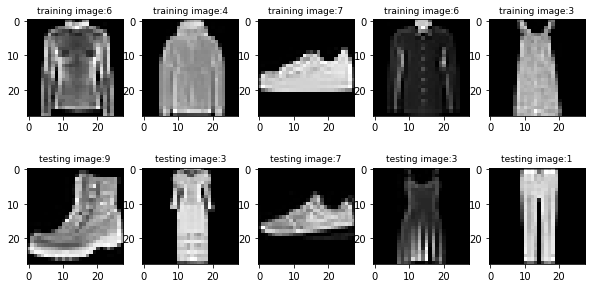

In [11]:
image = []
title = []
for i in range(0, 5):
    r = random.randint(1, len(X_train))
    image.append(X_train[r])
    title.append('training image:' + str(y_train[r]))       

for i in range(0, 5):
    r = random.randint(1, len(X_test))
    image.append(X_test[r])
    title.append('testing image:' + str(y_test[r]))
    
show(image, title)

In [12]:
class FashionMNISTDataset(Dataset):
    def __init__(self, csv_file, transform=None):
        self.annotations = pd.read_csv(csv_file)
        self.transform = transform

    def __len__(self):
        return len(self.annotations)

    def __getitem__(self, index):
        img = self.annotations.iloc[index, 1:]
        img = np.array(img,dtype='float32').reshape(28,28)
        # img_path = os.path.join(self.root_dir, self.annotations.iloc[index, 0])
        # image = io.imread(img_path)
        y_label = torch.tensor(int(self.annotations.iloc[index, 0]))

        if self.transform:
            img = self.transform(img)

        return (img, y_label)

In [13]:
train_set = FashionMNISTDataset("/content/Dataset_2/verification_train.csv",transforms.Compose([transforms.ToPILImage(), transforms.Resize(size=(28, 28)), transforms.ToTensor()]))
test_set = FashionMNISTDataset("/content/Dataset_2/verification_test.csv",transforms.Compose([transforms.ToPILImage(), transforms.Resize(size=(28, 28)), transforms.ToTensor()]))


In [16]:
# Hyperparameters
batch_size = 32
num_iters = 30000
input_dim = 28*28 # num_features = 784
num_hidden = 2000
output_dim = 10

learning_rate = 0.01
loss_lst = []
acc_lst = []

num_epochs = num_iters / (len(train_set) / batch_size)
num_epochs = int(num_epochs)

# Device
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")


train_loader = torch.utils.data.DataLoader(dataset=train_set,
                                           batch_size=batch_size, 
                                           shuffle=True)   # It's better to shuffle the whole training dataset! 

test_loader = torch.utils.data.DataLoader(dataset=test_set, 
                                          batch_size=batch_size, 
                                          shuffle=False) 

In [17]:
class DeepNeuralNetworkModel(nn.Module):
    def __init__(self, input_size, num_classes, num_hidden):
        super().__init__()
        ### 1st hidden layer: 784 --> 100
        self.linear_1 = nn.Linear(input_size, 2048)
        ### Non-linearity in 1st hidden layer
        self.relu_1 = nn.ReLU()

        ### 2nd hidden layer: 100 --> 100
        self.linear_2 = nn.Linear(2048, 1624)
        ### Non-linearity in 2nd hidden layer
        self.relu_2 = nn.ReLU()

        ### 3rd hidden layer: 100 --> 100
        self.linear_3 = nn.Linear(1624, 1248)
        ### Non-linearity in 3rd hidden layer
        self.relu_3 = nn.ReLU()

        ### 4th hidden layer: 100 --> 100
        self.linear_4 = nn.Linear(1248, 1024)
        ### Non-linearity in 4th hidden layer
        self.relu_4 = nn.ReLU()

        ### Output layer: 100 --> 10
        self.linear_out = nn.Linear(1024, num_classes)

    def forward(self, x):
        ### 1st hidden layer
        # x = x.view(x.shape[0], -1)
        out  = self.linear_1(x)
        ### Non-linearity in 1st hidden layer
        out = self.relu_1(out)
        
        ### 2nd hidden layer
        out  = self.linear_2(out)
        ### Non-linearity in 2nd hidden layer
        out = self.relu_2(out)

        ### 3rd hidden layer
        out  = self.linear_3(out)
        ### Non-linearity in 3rd hidden layer
        out = self.relu_3(out)

        ### 4th hidden layer
        out  = self.linear_4(out)
        ### Non-linearity in 3rd hidden layer
        out = self.relu_4(out)
        
        # Linear layer (output)
        probas  = self.linear_out(out)
        return probas

# INSTANTIATE MODEL CLASS

model = DeepNeuralNetworkModel(input_size = input_dim,
                               num_classes = output_dim,
                               num_hidden = num_hidden)


# To enable GPU
model.to(device)

criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.SGD(model.parameters(), lr=learning_rate)

In [18]:
iter = 0
for epoch in range(num_epochs):
    for i, (images, labels) in enumerate(train_loader):

        images = images.view(-1, 28*28).to(device)
        labels = labels.to(device)

        # Clear gradients w.r.t. parameters
        optimizer.zero_grad()

        # Forward pass to get output/logits
        outputs = model(images) 

        # Calculate Loss: softmax --> cross entropy loss
        loss = criterion(outputs, labels)

        # Getting gradients w.r.t. parameters
        loss.backward()

        # Updating parameters
        optimizer.step()

        iter += 1

        if iter % 500 == 0:
            # Calculate Accuracy         
            correct = 0
            total = 0
            # Iterate through test dataset
            for images, labels in test_loader:
               
                images = images.view(-1, 28*28).to(device)

                # Forward pass only to get logits/output
                outputs = model(images)

                # Get predictions from the maximum value
                _, predicted = torch.max(outputs, 1)

                # Total number of labels
                total += labels.size(0)


                # Total correct predictions
                if torch.cuda.is_available():
                    correct += (predicted.cpu() == labels.cpu()).sum() 
                else:
                    correct += (predicted == labels).sum()

            accuracy = 100 * correct.item() / total

            # Print Loss
            loss_lst.append(loss.item())
            acc_lst.append(accuracy)
            print('Iteration: {}. Loss: {}. Accuracy: {}'.format(iter, loss.item(), accuracy))

Iteration: 500. Loss: 0.7304405570030212. Accuracy: 83.0
Iteration: 1000. Loss: 0.27758726477622986. Accuracy: 84.0
Iteration: 1500. Loss: 0.4715214669704437. Accuracy: 85.52
Iteration: 2000. Loss: 0.337245911359787. Accuracy: 86.52
Iteration: 2500. Loss: 0.3105795681476593. Accuracy: 85.28
Iteration: 3000. Loss: 0.20504851639270782. Accuracy: 86.17
Iteration: 3500. Loss: 0.5773395299911499. Accuracy: 86.16
Iteration: 4000. Loss: 0.1688847541809082. Accuracy: 87.36
Iteration: 4500. Loss: 0.16005469858646393. Accuracy: 87.95
Iteration: 5000. Loss: 0.5179991126060486. Accuracy: 86.77
Iteration: 5500. Loss: 0.34915393590927124. Accuracy: 87.47
Iteration: 6000. Loss: 0.3678230941295624. Accuracy: 88.43
Iteration: 6500. Loss: 0.2155943512916565. Accuracy: 88.58
Iteration: 7000. Loss: 0.22365964949131012. Accuracy: 87.38
Iteration: 7500. Loss: 0.057742077857255936. Accuracy: 87.55
Iteration: 8000. Loss: 0.22835130989551544. Accuracy: 88.42
Iteration: 8500. Loss: 0.1635463386774063. Accuracy:

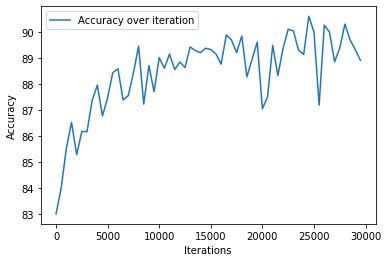

In [21]:
n_itr = np.arange(1,30000,500,int).tolist()
# len(n_itr)
plt.plot(n_itr,acc_lst,'-',label='Accuracy over iteration');
plt.xlabel('Iterations')
plt.ylabel('Accuracy')
plt.legend()
plt.savefig('acc_itr_ex03.png')
plt.show()

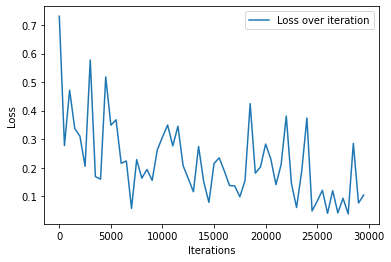

In [22]:
plt.plot(n_itr,loss_lst,'-',label='Loss over iteration');
plt.xlabel('Iterations')
plt.ylabel('Loss')
plt.legend()
plt.savefig('lss_itr_ex03.png')
plt.show()